In [1]:
# Source https://github.com/hughfdjackson/fluorescent-fibre-counting.git

from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from random import randint
from random import random
from math import floor, pi, cos, sin, tanh, sqrt

import numpy as np
import itertools

from scipy.ndimage import gaussian_filter, filters, interpolation
from multiprocessing import Pool
from datetime import datetime
from uuid import uuid4
import os
from google.colab.patches import cv2_imshow
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')


imagePath = r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis"

sample_images = os.path.join(imagePath, 'Data', 'synth', 'images', '')
sample_masks = os.path.join(imagePath, 'Data', 'synth', 'masks', '')

Mounted at /content/drive


In [9]:


class Component():
    """
        A component is some part of the generated image that knows
        how to draw itself.
    """

    def __init__(self, state):
        self.state = state

    @staticmethod
    def generate(config):
        """
            All randomness should be constrained to the this method; allowing
            the drawing of the images to be done in parallel.
        """
        pass

    def draw(self, image):
        return image

    def update_density_map(self, array):
        return array


def _generate_point(config, point, angle, rate_of_angle_change, curvature_sigma, curvature_limit):
    np.random.seed(_pick_natural(maximum = 1000))

    angle += rate_of_angle_change
    rate_of_angle_change += np.random.normal(loc = 0, scale = curvature_sigma)
    rate_of_angle_change = np.clip(rate_of_angle_change, -pi * curvature_limit, pi * curvature_limit)

    vector = _vector(angle, 1)
    new_point = (point[0] + vector[0], point[1] + vector[1])

    return new_point, angle, rate_of_angle_change


def _generate_path(config, length, bounds):
    curvature_sigma = _pick_float(config.min_curvature_sigma, config.max_curvature_sigma)
    curvature_limit = _pick_float(config.min_curvature_limit, config.max_curvature_limit)
    start_ = (_pick_float(config.image_dims[0]), _pick_float(config.image_dims[1]))

    point = clip_within_border(start_, config)
    angle = (_pick_float(0, 2 * pi))
    rate_of_angle_change = 0
    path = [point]

    for length_so_far in range(length):
        point, angle, rate_of_angle_change = _generate_point(
            config,
            point,
            angle,
            rate_of_angle_change,
            curvature_sigma,
            curvature_limit)

        path.append(point)

    return path, length

def _clip_color_change_rate(rate_of_color_change):
    return np.clip(rate_of_color_change, -50, 50)

def _generate_segment_color(color_range, color, rate_of_color_change):
    np.random.seed(_pick_natural(maximum = 1000))

    color += rate_of_color_change
    color = int(np.clip(color, *color_range))
    rate_of_color_change += np.random.normal(loc = 0, scale = 30)
    rate_of_color_change = _clip_color_change_rate(rate_of_color_change)

    return color, rate_of_color_change

def _apply_end_colour_penality(i, length, color, alpha_range, amount):
    start = tanh(i / amount) * alpha_range[1]
    end = tanh(length - i / amount) * alpha_range[1]

    alpha = int(min(start, end))

    return color[:3] + (alpha,)

def _generate_fibre_colors(length, color_range, alpha_range):
# Trial of generating solid black lines for fibres
    colors = [(0, 0, 0, 255)] * (length + 1)  # Generates a list of black color tuples
    return colors


def _generate_colors(length, color_range, alpha_range):
    np.random.seed(_pick_natural(maximum = 1000))

    alpha = _pick_natural(*alpha_range)

#    color_bound_1 = _pick_natural(*color_range)
    color_bound_1 = _pick_natural(*color_range[:3])  # Use only RGB values
    color_bound_2 = np.clip(
        int(np.random.normal(loc = color_bound_1, scale = 200)),
        *color_range
    )

    color_bounds = (
        min([color_bound_1, color_bound_2]),
        max([color_bound_1, color_bound_2]),
    )

    penalty_amount = _pick_float(1, 2)

    color = _pick_natural(*color_bounds)

    color_with_penalty = _apply_end_colour_penality(0, length, _color(color, alpha), alpha_range, penalty_amount)


    colors = [color_with_penalty]
    rate_of_color_change = _clip_color_change_rate(_pick_natural(-50, 50))

    for i in range(length):
        color, rate_of_color_change = _generate_segment_color(color_bounds, color, rate_of_color_change)

        color_with_penalty = _apply_end_colour_penality(i + 1, length, _color(color, alpha), color_range, penalty_amount)
        colors.append(color_with_penalty)

    return colors

def _color(i, alpha = 255):
    return (i, i, i, alpha)

def _draw_fibre(state, image, isMask=False):
    image = state['bubble'].draw(image)
    path = state['path']

    draw = ImageDraw.Draw(image, 'RGBA')

    segments = zip(path[:-1], path[1:])

    if isMask == False:
        for segment, color in zip(segments, state['color']):
            draw.line(
                segment,
                fill = color,
                width = state['width']
            )
    else:
        color = generate_random_color()
        for segment in segments:
            draw.line(
                segment,
                fill = color,
                width = state['width']
            )


    return image

def generate_random_color():
    red = randint(0, 253)
    green = randint(0, 253)
    blue = randint(0, 253)
    alpha = 255
    return (red, green, blue, alpha)



def _vector(angle, length):
    return (cos(angle) * length, sin(angle) * length)

class Fibre(Component):

    @staticmethod
    def generate(config):
        width = _pick_natural(config.min_fibre_width, config.max_fibre_width)
        max_length = _pick_natural(config.min_fibre_length, config.max_fibre_length)
        path, length = _generate_path(config, max_length, config.image_dims)

        return Fibre({
            'path': path,
            #'color': _generate_colors(length, (125, 200), (150, 255)),
            'color': _generate_fibre_colors(length, (0, 0), (255, 255)),
            'width': width,
            'bubble': FibreBubble.generate(path, width),
            'length': length,
            'image_dims': config.image_dims
        })

    def draw(self, image, isMask=False):
        return _draw_fibre(self.state, image, isMask)

    def update_density_map(self, array):
        def point_to_int(point):
            return (int(point[0]), int(point[1]))

        path = self.state['path']
        start = point_to_int(path[0])
        end = point_to_int(path[-1])

        if _point_is_within_bounds(start, array.shape):
            array[start[1], start[0]] += 1

        if _point_is_within_bounds(end, array.shape):
            array[end[1], end[0]] += 1

        return array

def _point_is_within_bounds(point, bounds):
    return (point[1] < bounds[0] and
            point[1] >= 0 and
            point[0] < bounds[1] and
            point[0] >= 0)

class NonFluorescentFibre(Component):
    """
        Fibres that are much darker than the fluorescent fibres in the image.
    """
    @staticmethod
    def generate(config):
        width = _pick_natural(config.min_fibre_width, config.max_fibre_width)
        max_length = _pick_natural(config.min_fibre_length, config.max_fibre_length)
        path, length = _generate_path(config, max_length, config.image_dims)

        return NonFluorescentFibre({
            'path': path,
            #'color': _generate_colors(length, (0, 0), (255, 255)),
            'color': _generate_fibre_colors(length, (0, 0), (255, 255)),
            'width': width,
            'bubble': FibreBubble.generate(path, width)
        })

    def draw(self, image, isMask=False):
        return _draw_fibre(self.state, image, isMask)

class FibreBubble(Component):

    @staticmethod
    def generate(path, width):
        return FibreBubble({
            'path': path,
            'width': floor(width * _pick_float(2.0, 7.0)),
            'alpha': _pick_natural(0, 3)
        })

    def draw(self, image):
        points = self.state['path']

        bubble_color = _color(255, self.state['alpha'])

        draw = ImageDraw.Draw(image, 'RGBA')
        draw.line(points, width = self.state['width'], fill = bubble_color)

        return image

_noise_shape = (2 ** 12), (2 ** 12)
_noise = np.random.normal(np.empty(_noise_shape)).repeat(3).reshape(_noise_shape + (3,))


class Background(Component):

    @staticmethod
    def generate(config):
        np.random.seed(_pick_natural(maximum = 324230432))
        return Background({
            #'color': _color(_pick_natural(0, 50)),
            'color': _color(_pick_natural(200, 255)),  # Set background to white
            'bounding_box': [(0, 0), config.image_dims],
            'noise_degree': _pick_float(0, 5),
            'noise_shift': (_pick_natural(0, 100), _pick_natural(0, 100)),
            'image_dims': config.image_dims
        })

    def draw(self, image):
        draw = ImageDraw.Draw(image, 'RGBA')
        draw.rectangle(self.state['bounding_box'], fill = self.state['color'])

        w, h = self.state['image_dims']
        noise = np.roll(_noise[:h, :w, :], self.state['noise_shift'], axis = (0, 1))
        noise *= self.state['noise_degree']

        array = np.asarray(image).astype('float32')
        array[:, :, :3] += noise
        array = np.clip(array, 0, array.max())

        return Image.fromarray(array.astype('uint8'))

class TapeLine(Component):

    @staticmethod
    def generate(config):
        w, h = config.image_dims

        angle = _pick_float(-pi, pi)

        # If we go this length in each direction from any starting point,
        # we're guaranteed to be outside of the image
        length_from_point = int(sqrt(w ** 2 + h ** 2))

        start_vec = _vector(angle, length_from_point)
        end_vec = _vector(angle, -length_from_point)

        xy = (_pick_natural(0, w), _pick_natural(0, h))

        start = _tuple_addition(xy, start_vec)
        end = _tuple_addition(xy, end_vec)

        num_segments = length_from_point * 2

        path = list(zip(
            np.linspace(start[0], end[0], num_segments),
            np.linspace(start[1], end[1], num_segments),
        ))

        # colors = _generate_colors(num_segments, (50, 150), (50, 50))
        colors = _generate_colors(num_segments, (0, 50), (50, 50))

        return TapeLine({
            'path': path,
            'colors': colors
        })

    def draw(self, image):
        draw = ImageDraw.Draw(image, 'RGBA')
        path = self.state['path']

        segments = zip(path[:-1], path[1:])

        for segment, color in zip(segments, self.state['colors']):
            draw.line(segment, fill = color)

        return image

def _tuple_addition(xs, ys):
    return tuple(x + y for x, y in zip(xs, ys))


class Blur(Component):

    @staticmethod
    def generate(config):
        return Blur({
            'radius': _pick_float(.5, 1.)
        })

    def draw(self, image):
         return image.filter(ImageFilter.GaussianBlur(radius = self.state['radius']))


class DensityMapBlur(Component):

    sigma = 1

    @staticmethod
    def generate(config):
        return DensityMapBlur({})

    def update_density_map(self, array):
        return gaussian_filter(array, sigma = self.sigma, mode = 'constant', cval = 0.0)


class Config:

    def __init__(self,
           #image_dims = (64, 64),
           image_dims = (1064, 1064),

           #max_fibres = 10, min_fibres = 1,
           max_fibres = 1, min_fibres = 1,
           max_fibre_width = 3, min_fibre_width = 1,
           max_fibre_length = 325, min_fibre_length = 50,
           max_background_fibres = 1, min_background_fibres = 0,
           min_curvature_sigma = .00, max_curvature_sigma = .25,
           min_curvature_limit = .025, max_curvature_limit = .15
       ):

        self.image_dims = image_dims
        self.max_fibres = max_fibres
        self.min_fibres = min_fibres
        self.max_fibre_width = max_fibre_width
        self.min_fibre_width = min_fibre_width
        self.max_fibre_length = max_fibre_length
        self.min_fibre_length = min_fibre_length
        self.max_background_fibres = max_background_fibres
        self.min_background_fibres = min_background_fibres
        self.min_curvature_sigma = min_curvature_sigma
        self.max_curvature_sigma = max_curvature_sigma
        self.min_curvature_limit = min_curvature_limit
        self.max_curvature_limit = max_curvature_limit


def _pick_natural(minimum = 0, maximum = 1):
    return int(round(random() * (maximum - minimum)) + minimum)

def _pick_float(minimum = 0, maximum = 1.0):
    return (random() * (maximum - minimum)) + minimum


def clip_within_border(point, config):
    x, y = point
    w_, h_ = config.image_dims

    ## To avoid points on the edge of the image
    w, h = w_ - 5, h_ - 5
    return np.clip(x, 5, w), np.clip(y, 5, h)

def pick_fibre_number(config):
    #return _pick_natural(config.min_fibres, config.max_fibres + 1)
    return 1  # for initial tests, I'll have one fibre on each image


def gen_components(config):
    num_fibres = pick_fibre_number(config)
    #num_background_fibres = _pick_natural(config.min_background_fibres, config.max_background_fibres)

    background = Background.generate(config)

    fluorescent_fibres = [Fibre.generate(config) for i in range(num_fibres)]
    #background_fibres = [NonFluorescentFibre.generate(config) for i in range(num_background_fibres)]
    #fibres = (fluorescent_fibres + background_fibres)
    fibres = fluorescent_fibres
    fibres.sort(key = lambda x: random())
    tape_line = TapeLine.generate(config)

    blur = Blur.generate(config)
    density_map_blur = DensityMapBlur.generate(config)

    return [background] + fibres + [tape_line, blur, density_map_blur]

def create_fibre_image(components, config):
    image = Image.new('RGB', config.image_dims)
    # DOS Addition
    # eventid = datetime.now().strftime('%Y%m-%d%H-%M%S-') + str(uuid4())

    for component in components:
        # print(component)
        image = component.draw(image)

        # if isinstance(component, Fibre):
        #     print('fibre')
        # else:
        # # Code to execute when the component does not match any expected class
        #     print("Component does not match any expected class")


    # image.convert('L').save(eventid+"xxx.png","PNG")
    # image.convert('P').save(eventid+".png","PNG")

    return image.convert('L')

def create_fibre_mask(components, config):


    image_mask = Image.new('RGB', config.image_dims)
    for component in components:
        if isinstance(component, Fibre):
            image_mask = component.draw(image_mask, True)
            print(np.max(image_mask))
    return image_mask.convert('L')

def create_density_map(components, config):
    w, h = config.image_dims
    array = np.zeros((h, w)) # for whatever reason, numpy prefers it in h -> w format

    for component in components:
        array = component.update_density_map(array)

    return array

def render_components(components, config):
    w, h = config.image_dims
    image = np.asarray(create_fibre_image(components, config)).reshape(h, w, 1)
    image_mask = np.asarray(create_fibre_mask(components, config)).reshape(h, w, 1)

    # density_map = np.asarray(create_density_map(components, config)).reshape(h, w, 1)
    #count = np.sum(density_map) / 2.
    count = 1

    return (image, image_mask, count)

def render_components_set(components_set, config):
    with Pool() as p:
        return p.starmap(render_components, zip(components_set, itertools.repeat(config)))

def generate_training_example(config):
    return render_components(gen_components(config), config)

## Training set
def training_set(size, config):
    components_set = [gen_components(config) for i in range(size)]
    values = zip(*render_components_set(components_set, config))
    return tuple(np.array(v) for v in values)

In [23]:

import os
from datetime import datetime
import cv2
from PIL import Image
from random import seed
# from generate import (
#     generate_training_example,
#     training_set,
#     Config,
#     Fibre,
#     gen_components
#)


import numpy as np
import math


# get_contours and store_polygons taken from  https://github.com/computervisioneng/image-segmentation-yolov8
# used to convert masks into YOLO suitable labels
def get_contours( inboundMask ):

    _, mask = cv2.threshold(inboundMask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(inboundMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
       # if cv2.contourArea(cnt) > 200:
        polygon = []
        for point in cnt:
            x, y = point[0]
            polygon.append(x / W)
            polygon.append(y / H)
        polygons.append(polygon)

    return polygons


def store_polygons(directory, file,  inboundPolygons):
    # print the polygons
    with open('{}.txt'.format(os.path.join(directory, file)[:-4]), 'w') as f:
        for polygon in inboundPolygons:
            for p_, p in enumerate(polygon):
                if p_ == len(polygon) - 1:
                    f.write('{}\n'.format(p))
                elif p_ == 0:
                    f.write('0 {} '.format(p))
                else:
                    f.write('{} '.format(p))

        f.close()



def test_generation_is_deterministic(image_destination, mask_destination, label_destination):
    test_seed = 120

    seed(test_seed)
    data1, label1, count1 = training_set(1, Config())

    for i, (image, mask) in enumerate(zip(data1, label1), 1):
        current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S-%f')
        Image.fromarray(image.squeeze(), mode="L").save(f"{image_destination}image_{current_time}.png")
        #Image.fromarray(image.squeeze(), mode="P").save(f"{image_destination}image_{current_time}.png")
        max_value = np.max(mask.squeeze())
        print("Maximum value in the image mask 2:", max_value)
        Image.fromarray(mask.squeeze(), mode="L").save(f"{mask_destination}mask_{current_time}.png")
        store_polygons(label_destination, f"label_{current_time}.txt",  get_contours(mask))



In [24]:
import os


imagePath = r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis"
current_directory = os.getcwd()
print(current_directory)
#current_directory = os.path.dirname(os.path.abspath(__file__))
sample_images = os.path.join(imagePath, 'Data', 'synth', 'images', '')
sample_masks = os.path.join(imagePath, 'Data', 'synth', 'masks', '')
sample_labels = os.path.join(imagePath, 'Data', 'synth', 'labels', '')
print(sample_masks)
print(sample_images)

print("Running File Creation")
test_generation_is_deterministic(sample_images , sample_masks , sample_labels)
print("Complete")

/content
/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/masks/
/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/images/
Running File Creation
131
Maximum value in the image mask 2: 121
Complete


In [25]:

# Quick check to see if a bounding box was found

vesMask = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/masks/mask_2023-06-23_20-49-12-135400.png", 0)
max_value = np.max(vesMask)
print("Maximum value in the image mask 3:", max_value)

Maximum value in the image mask 3: 121


Maximum value in the image mask: 1
tensor([[417., 382., 451., 408.]])


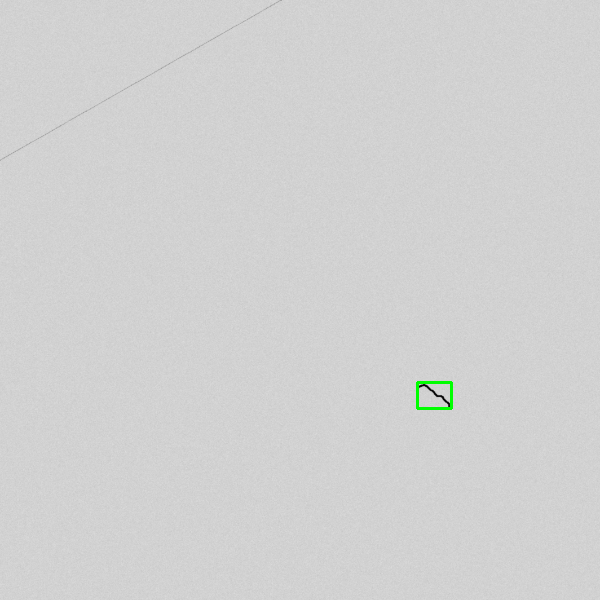

In [26]:
# display the bounding box around the relevant segmentation
imageSize=[600,600]
batch_Imgs=[]
batch_Data=[]
masks=[]
img = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/images/image_2023-06-23_20-49-12-135400.png")
img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)



#vesMask = cv2.imread(os.path.join(sample_masks , maskFile), 0)
vesMask = cv2.imread(r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth/masks/mask_2023-06-23_20-49-12-135400.png", 0)
#"C:\Users\dezos\Documents\Fibres\FibreAnalysis\Data\synth\masks\mask_2023-06-23_18-25-29-244708.png"

vesMask = (vesMask > 0).astype(np.uint8)
vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)

max_value = np.max(vesMask)

print("Maximum value in the image mask:", max_value)

masks.append(vesMask)
num_objs = 1

if num_objs==0: print('none')
boxes = torch.zeros([num_objs,4], dtype=torch.float32)

for i in range(num_objs):
    x,y,w,h = cv2.boundingRect(masks[i])
    boxes[i] = torch.tensor([x, y, x+w, y+h])

masks = torch.as_tensor(masks, dtype=torch.uint8)

tempImg = img

img = torch.as_tensor(img, dtype=torch.float32)
data = {}
print(boxes)
data["boxes"] =  boxes
data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)
data["masks"] = masks
batch_Imgs.append(img)
batch_Data.append(data)

# Draw the bounding box on the image
cv2.rectangle(tempImg, (x, y), (x + w, y + h), (0, 255, 0), 2)

# # Display the image
cv2_imshow( tempImg)

# # Wait for a key press and close the windows
cv2.waitKey(0)
cv2.destroyAllWindows()